https://docs.pymc.io/notebooks/getting_started.html

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm


### Linear regression
We want to predict Y with normally distributed observations with an expected value and standard deviation

$$
Y = \mathcal{N}(\mu, \sigma^{2})
$$

And expected value mu is a linear function of X1 and X2
$$
\mu = \alpha + \beta_1X_1 + \beta_2X_2
$$

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np


In [4]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [5]:
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

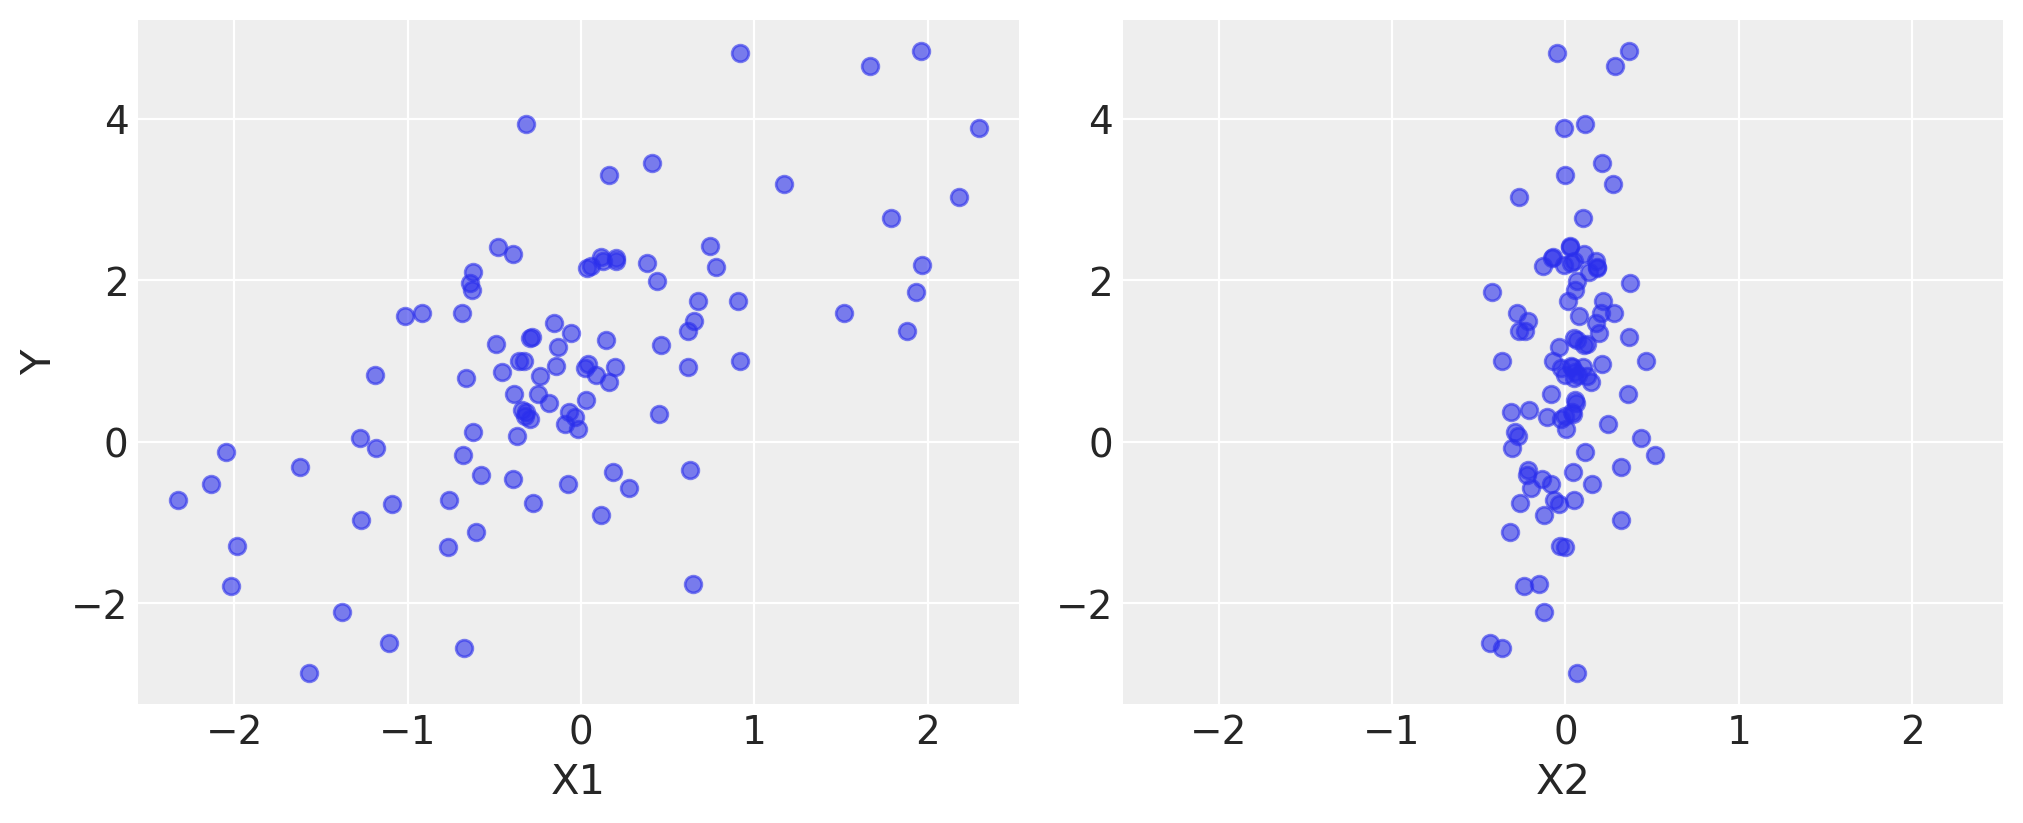

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [7]:
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [8]:
basic_model = pm.Model() # creates a new model object which is a container for teh model random variables. 
# Following instantiation of the model, the subsequent specification of the model components is performed

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)



In [9]:
map_estimate = pm.find_MAP(model=basic_model)

In [10]:
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

In [11]:
with basic_model:
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

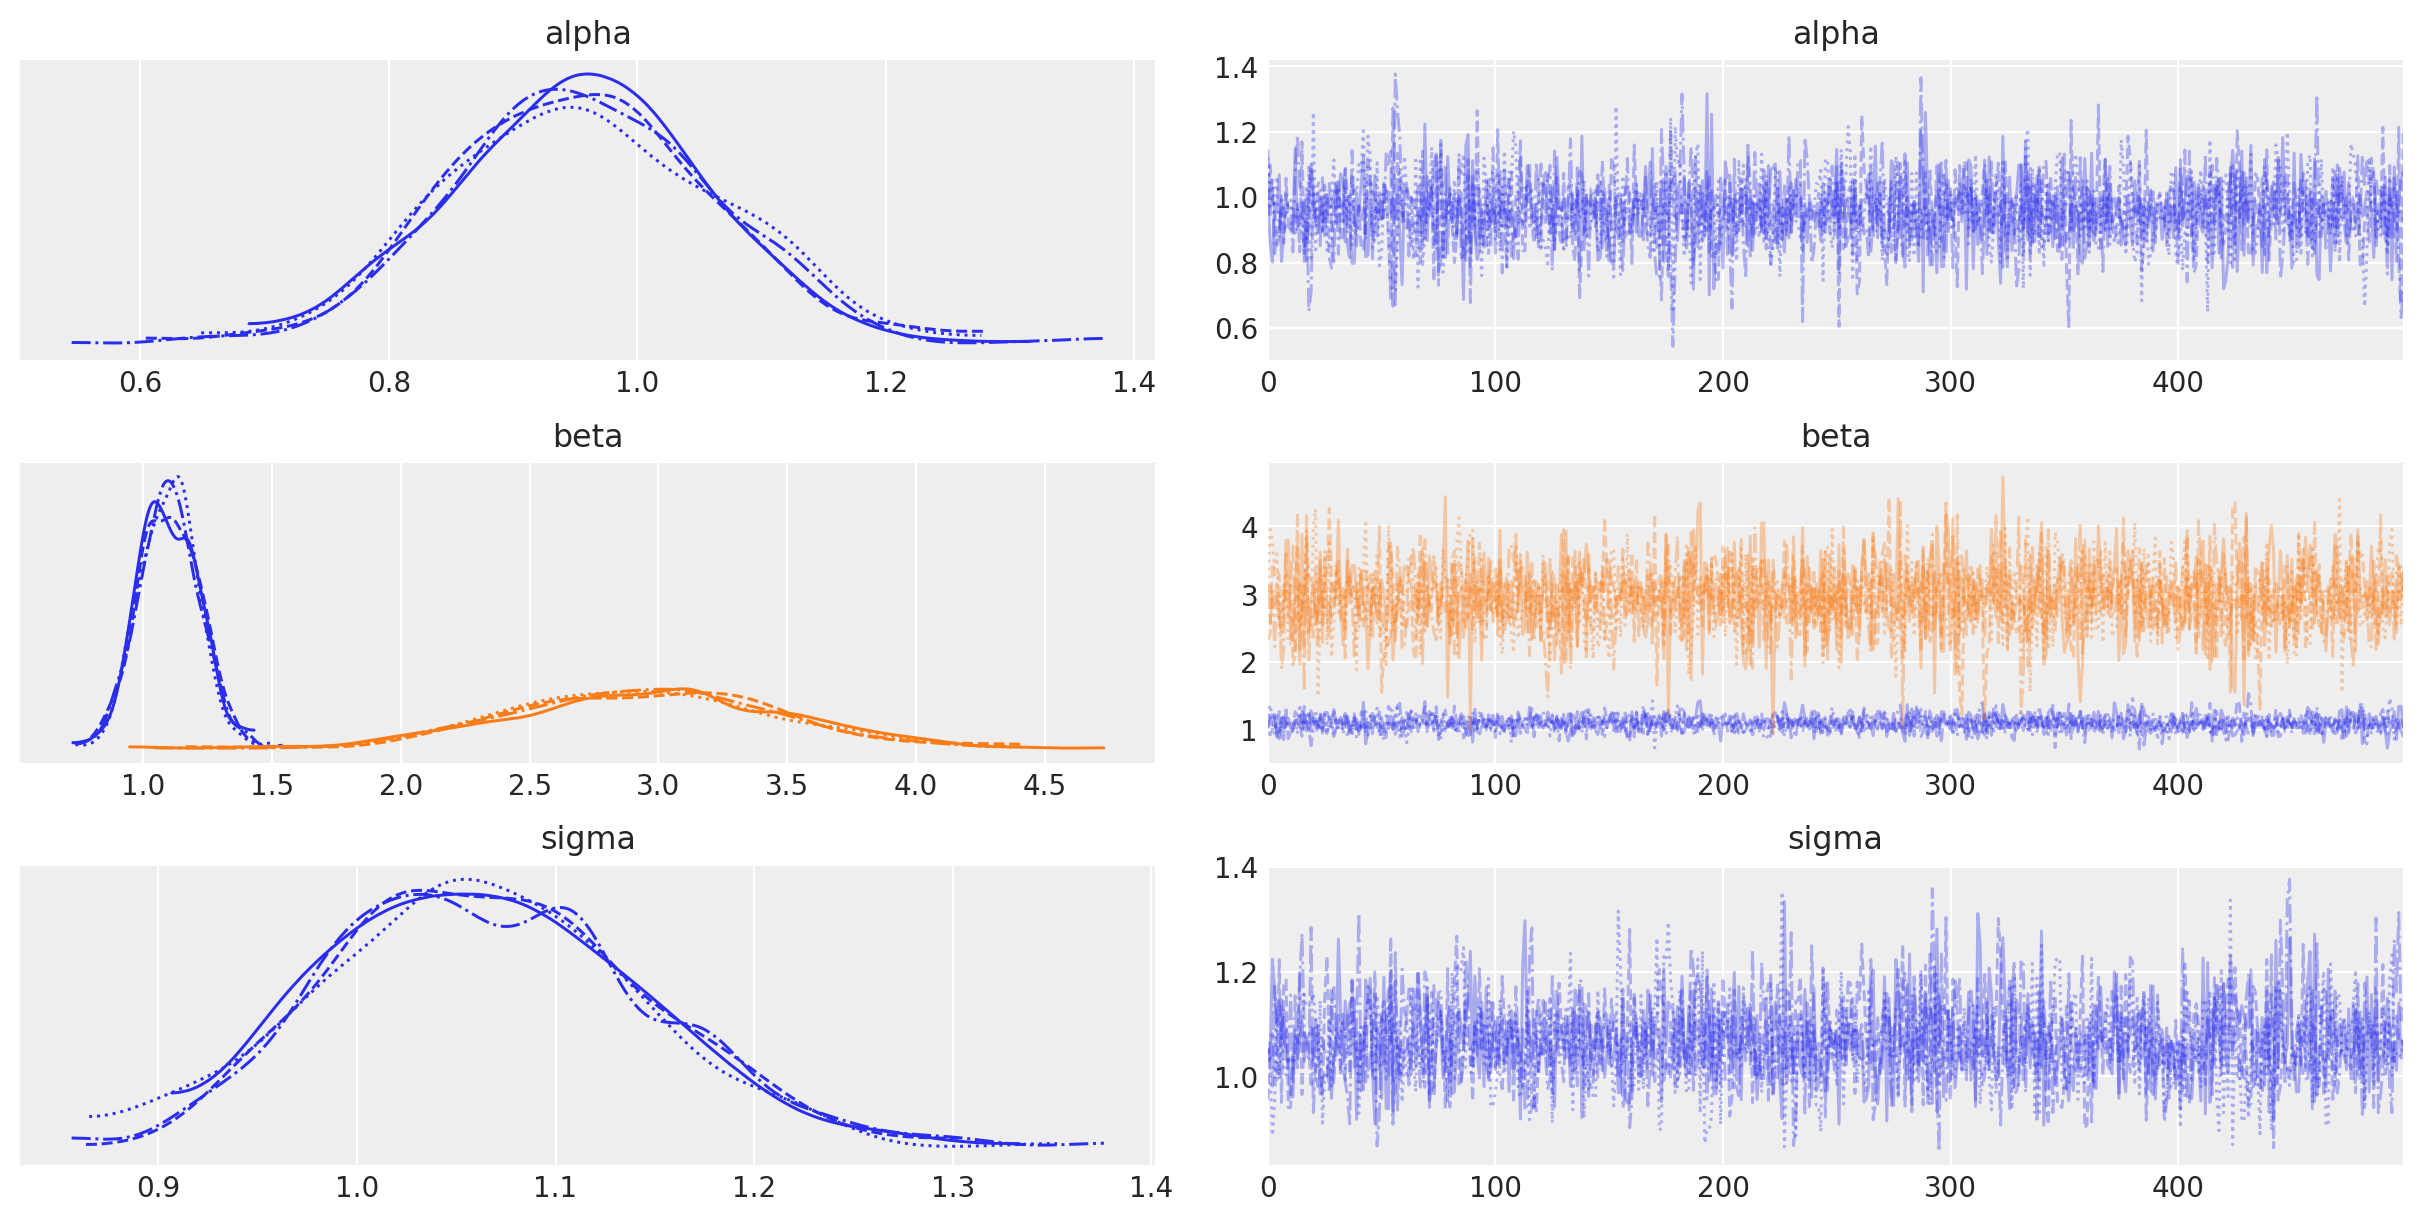

In [13]:
with basic_model:
    az.plot_trace(trace)

In [14]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.96,0.11,0.77,1.16,0.00,0.00,3015.12,1587.85,1.0
beta[0],1.10,0.12,0.88,1.30,0.00,0.00,2779.68,1661.43,1.0
beta[1],2.95,0.52,1.96,3.89,0.01,0.01,3201.84,1743.37,1.0
sigma,1.07,0.08,0.93,1.23,0.00,0.00,2476.47,1202.15,1.0


### Case study: stochastic validity

time varying stock market volatility

$$
v = exp(0.1)
$$
$$
\sigma = exp(50)
$$
$$
s_i = \mathcal{N}(s_{i-1}, \sigma^{2})
$$
$$
log(r_i) = t(v, 0, exp(-2s_i))
$$

here, r is the daily return series which is modeled with a student t distribution with an unknown degrees of freedom parameter determined by a latent processs s. The individual s<sub>i</sub> are the individual daily log volatilities in the latent log volatility process

In [15]:
returns = pd.read_csv(pm.get_data("SP500.csv"), parse_dates=True, index_col=0, usecols=["Date", "change"])
returns.shape

(2906, 1)

<AxesSubplot:xlabel='Date'>

Text(0, 0.5, 'daily returns in %')

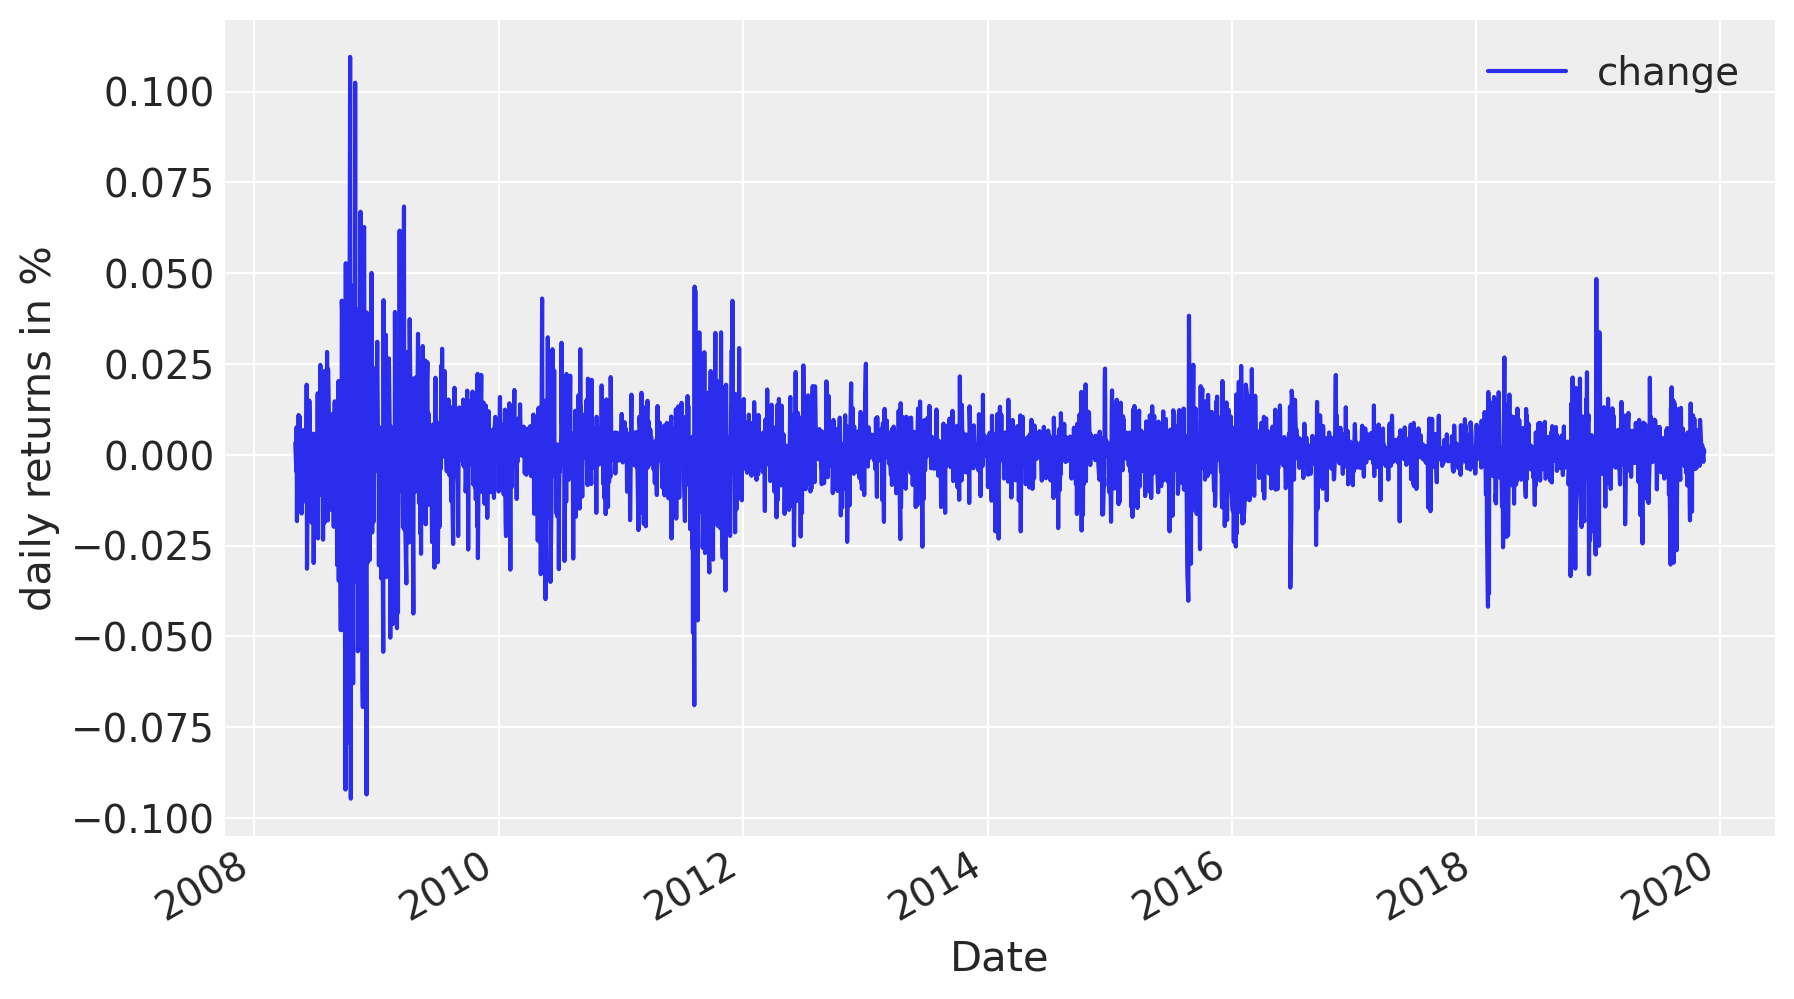

In [17]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    returns.plot(figsize=(10, 6))
    plt.ylabel("daily returns in %");



In [18]:
with pm.Model() as sp500_model:
    # the model remembers the datetime index with the name "date"
    change_returns = pm.Data("returns", returns["change"], dims="date", export_index_as_coords=True)
    
    nu = pm.Exponential("nu", 1/10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)
    
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="date")
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )
    
    r = pm.StudentT("r", nu=nu, sigma=volatility_process, observed=change_returns, dims="date")

In [19]:
sp500_model.RV_dims

{'returns': ('date',),
 's': ('date',),
 'volatility_process': ('date',),
 'r': ('date',)}

In [20]:
sp500_model.coords

{'date': DatetimeIndex(['2008-05-02', '2008-05-05', '2008-05-06', '2008-05-07',
                '2008-05-08', '2008-05-09', '2008-05-12', '2008-05-13',
                '2008-05-14', '2008-05-15',
                ...
                '2019-11-01', '2019-11-04', '2019-11-05', '2019-11-06',
                '2019-11-07', '2019-11-08', '2019-11-11', '2019-11-12',
                '2019-11-13', '2019-11-14'],
               dtype='datetime64[ns]', name='Date', length=2906, freq=None)}

### Fitting

In [21]:
with sp500_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 192 seconds.


0, dim: date, 2906 =? 2906


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date, 2906 =? 2906
0, dim: date, 2906 =? 2906


array([[<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

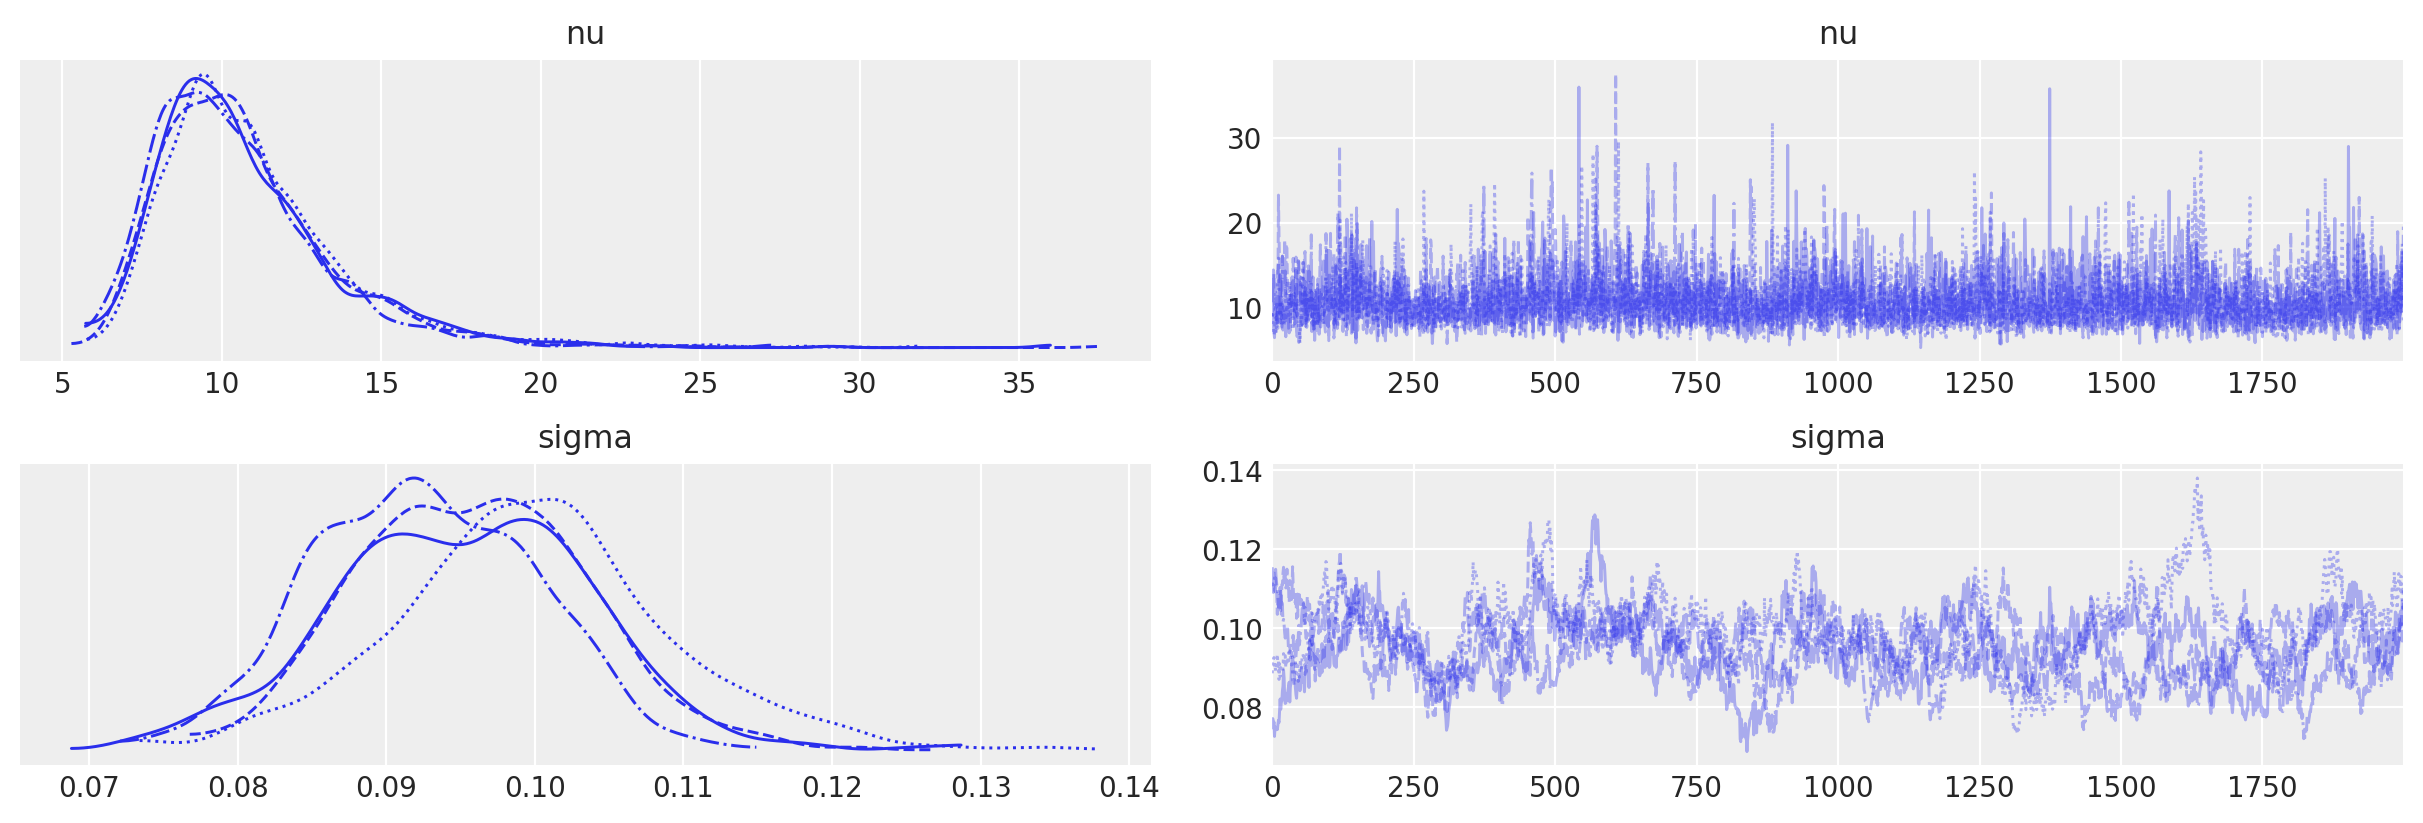

In [22]:
with sp500_model:
    az.plot_trace(trace, var_names=["nu", "sigma"]);